# Features approach

In [156]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from utils import *

In [ ]:
# Load data
dataset_path = "data/postgis_output/"
feature_dataset = load_and_preprocess_multiple_csv_from_path(dataset_path, \
                                                            preprocess_function=preprocess_features_dataset,\
                                                            dtype={'edifc_uso': object})
feature_balanced_dataset = balance_dataset(feature_dataset, "edifc_uso_desc")

In [53]:
#feature_dataset.to_csv('data/cache/cached_features_dataset.pkl', index=False)
#feature_balanced_dataset.to_csv('data/cache/cached_features_balanced_dataset.pkl', index=False)

#feature_dataset = pd.read_csv('data/cache/cached_features_dataset.pkl')
#feature_balanced_dataset = pd.read_csv('data/cache/cached_features_balanced_dataset.pkl')

In [114]:
feature_balanced_dataset.describe()

,footprint_id,max_in_footprint,percentile_20_in_footprint,percentile_40_in_footprint,percentile_60_in_footprint,percentile_80_in_footprint,min_overrall,building_height,roof_height,footprint_area
count,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000,8992.000000
mean,37448.118661,181.711984,173.156603,174.521226,175.631322,176.738402,162.503488,19.208496,7.190758,902.754409
std,21831.977001,13.577540,11.443327,11.739878,11.978229,12.169357,9.991168,11.415422,7.038620,1814.475080
min,1.000000,146.300000,142.590000,142.764000,144.300000,144.570000,139.560000,0.100000,0.000000,0.164933
25%,18628.000000,172.040000,163.499500,164.530000,165.775000,167.045000,154.600000,10.640000,2.320000,174.037873
50%,37051.500000,182.340000,173.775000,175.361000,176.468000,177.605000,160.630000,17.245000,5.658000,420.195076
75%,56321.250000,190.260000,181.383000,182.860000,183.991000,185.072500,170.132500,25.962500,9.560000,974.201336
max,75271.000000,294.740000,238.330000,239.550000,245.940000,247.050000,190.610000,134.910000,111.620000,74956.983976


In [195]:
# Prepare data for ML
feature_cols = ['max_in_footprint', 'percentile_20_in_footprint', 'percentile_40_in_footprint', \
              'percentile_60_in_footprint', 'percentile_80_in_footprint', 'min_overrall', \
              'building_height', 'roof_height', 'footprint_area']
              
X = feature_balanced_dataset[feature_cols].values
y, labels_encoder = multiclass_label_encoder(feature_balanced_dataset["edifc_uso_desc"].values)

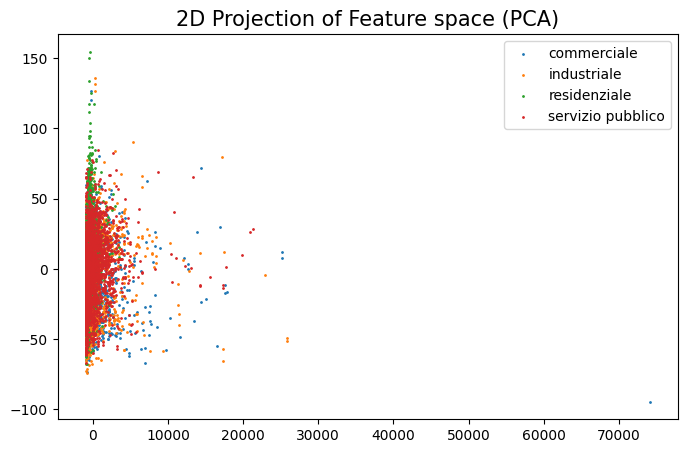

In [186]:
plot_vectors(X, y, labels_encoder, title="2D Projection of Feature space (PCA)", figsize=(8, 5))

In [118]:
# The flag stratify creates a split with the same proportion of classes in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Ravel the labels to avoid warnings w/ following ML models
y_train, y_test = y_train.ravel(), y_test.ravel()

# Scale the features due to tested improvements in the performance
standard_scaler = preprocessing.StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

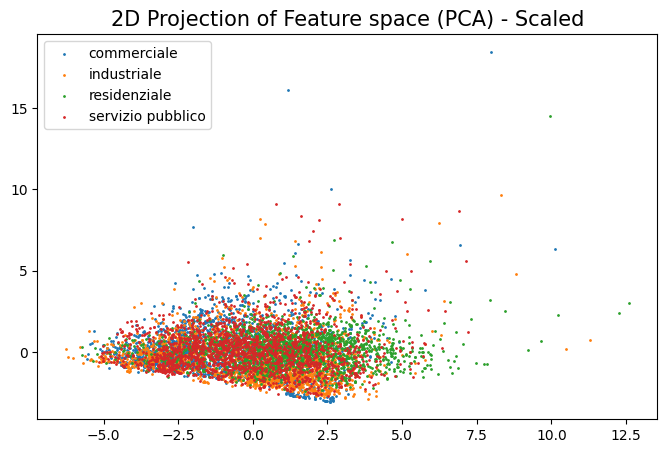

In [187]:
plot_vectors(X_train_standard, y_train, labels_encoder, title="2D Projection of Feature space (PCA) - Scaled", figsize=(8, 5))

## Knn

In [209]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, validation_curve
from mlxtend.plotting import plot_decision_regions

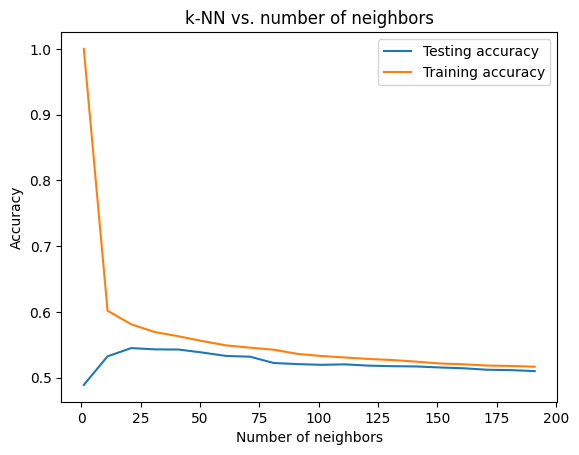

In [188]:
neighbors = range(1,200,10)
knn_train_score, knn_val_score = validation_curve(kNN(), X_train_standard, y_train.ravel(), param_name='n_neighbors', param_range=neighbors, cv=5)

plt.title('k-NN vs. number of neighbors')
plt.plot(neighbors, np.mean(knn_val_score, 1), label='Testing accuracy')
plt.plot(neighbors, np.mean(knn_train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [210]:
k_grid = {'n_neighbors': range(1, 75, 3)}
knn_learner = GridSearchCV(estimator=kNN(), param_grid=k_grid, cv=5, return_train_score=True)
knn_learner.fit(X_train_standard, y_train)
knn_learner.best_params_, knn_learner.best_score_

({'n_neighbors': 28}, 0.5471966604841679)

In [211]:
knn_model = knn_learner.best_estimator_
knn_cv_scores = cross_val_score(knn_model, X_train_standard, y_train, cv=5)
print("Cross-Validation Score for best KNN model: ", knn_cv_scores.mean())

Cross-Validation Score for best KNN model:  0.5471966604841679


In [215]:
y_pred_knn = knn_model.predict(X_test_standard)

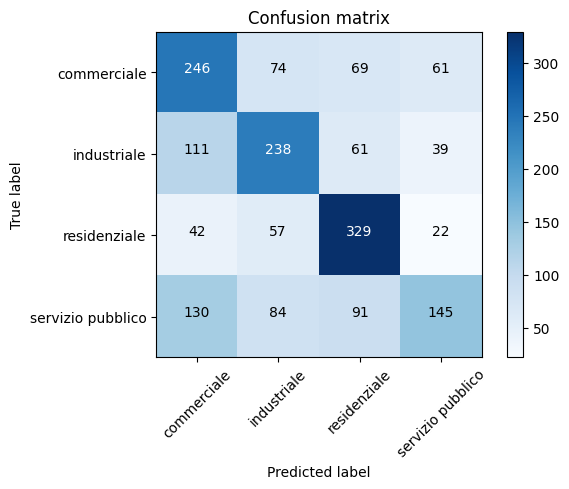

In [216]:
# Compute and plot the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_knn) 
plot_confusion_matrix(confusion_mtx, labels_encoder, title='Confusion matrix - KNN') 

/Users/billy/Documents/university/dse/statistical_methods_for_machine_learning/MSA/.venv/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:300: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


Text(0, 0.5, 'mean_texture')

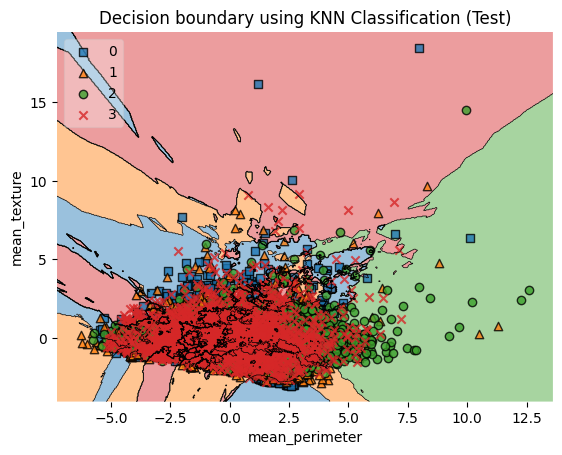

In [217]:
pca = decomposition.PCA(n_components=2)
X_train_standard_pca = pca.fit_transform(X_train_standard)
knn_model.fit(X_train_standard_pca, y_train.ravel())
plot_decision_regions(X_train_standard_pca, y_train.astype(int), clf = knn_model, legend = 2)
plt.title("Decision boundary using KNN Classification (Test)")
plt.xlabel("mean_perimeter")
plt.ylabel("mean_texture")

## Decision Tree

In [222]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

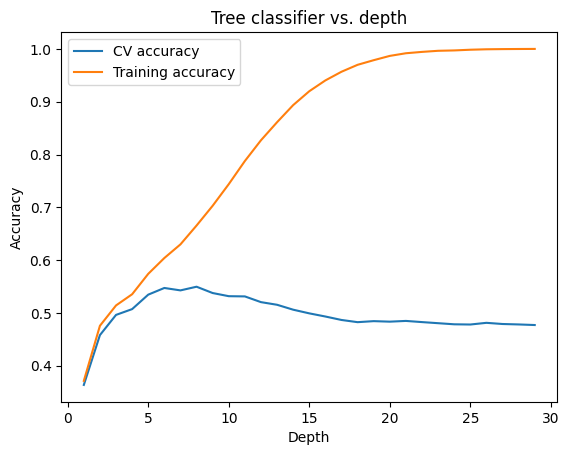

In [235]:
depths = np.arange(1,30,1)
learner = DecisionTreeClassifier()
train_score, val_score = validation_curve(learner, X_train_standard, y_train, param_name='max_depth', param_range=depths, cv=3)

plt.title('Tree classifier vs. depth')
plt.plot(depths, np.mean(val_score, 1), label='CV accuracy')
plt.plot(depths, np.mean(train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

In [236]:
k_grid = {'max_depth': range(1, 30, 1)}
tree_learner = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=k_grid, cv=3, return_train_score=True)
tree_learner.fit(X_train_standard, y_train)
tree_learner.best_params_, tree_learner.best_score_

({'max_depth': 8}, 0.5509526260063056)

In [247]:
tree_model = tree_learner.best_estimator_
tree_cv_scores = cross_val_score(tree_model, X_train_standard, y_train, cv=5)
print("Cross-Validation Score for best Tree model: ", tree_cv_scores.mean())

Cross-Validation Score for best Tree model:  0.5522036145870887


In [238]:
y_pred_tree = tree_model.predict(X_test_standard)

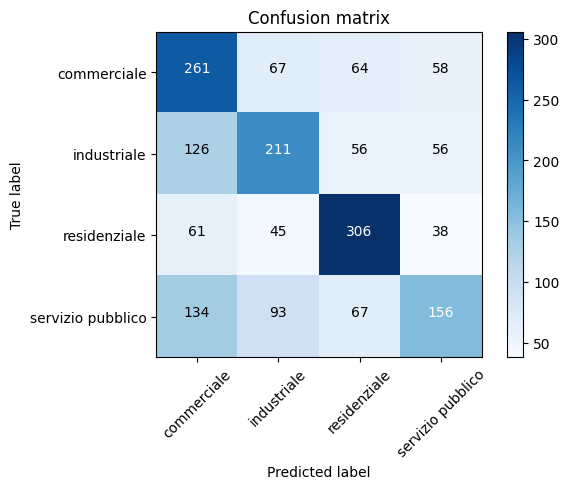

In [239]:
# Compute and plot the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_tree) 
plot_confusion_matrix(confusion_mtx, labels_encoder, title='Confusion matrix - Decision Tree')

In [ ]:
# Cannot represent tree decision boundary on 9 dimensions

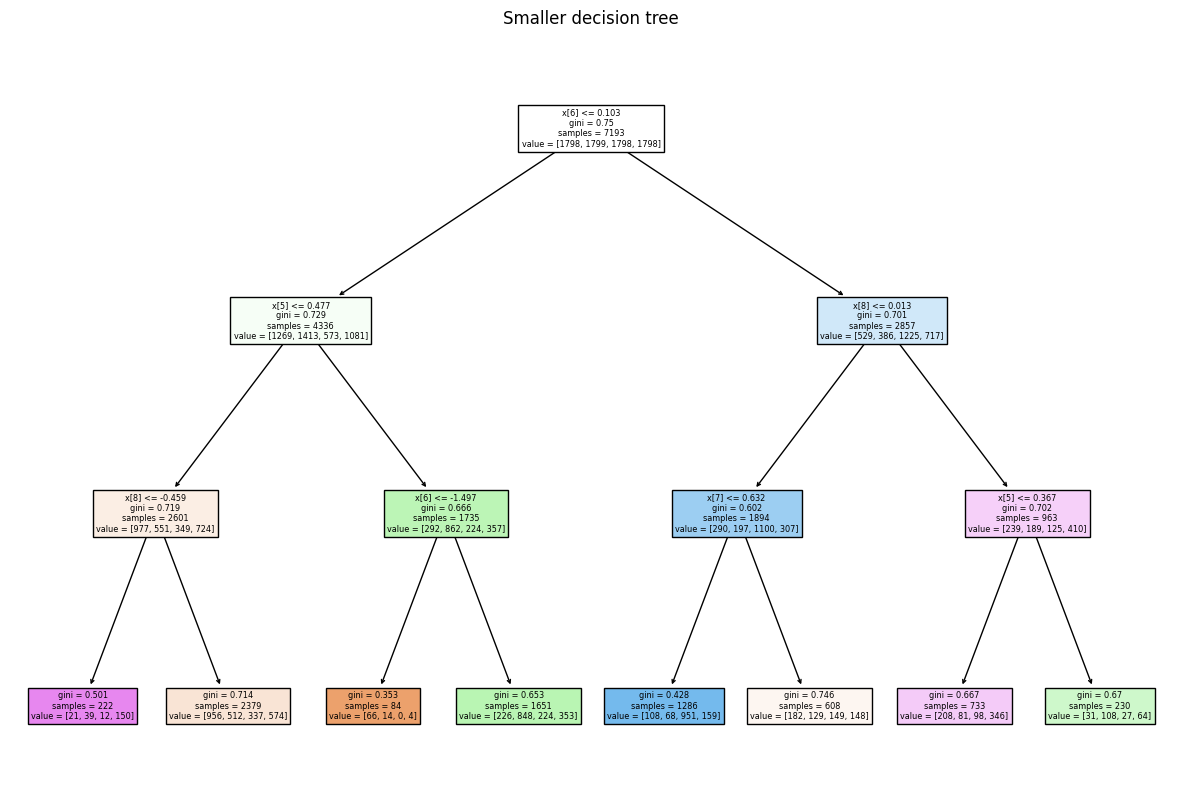

In [256]:
# Tree is too big to represent properly, we just represent a smaller tree
from sklearn.tree import plot_tree

# Create and train model
clf = DecisionTreeClassifier(max_depth=3)  # set hyperparameter
clf.fit(X_train_standard, y_train)

plt.figure(figsize=(15,10))
plot_tree(clf, filled=True)
plt.title("Smaller decision tree")
plt.show()